# Managing and Creating QComponents

### Preparations

Preload python packages.

In [1]:
%load_ext autoreload
%autoreload 2
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict

Create a design and open the GUI

In [2]:
design = designs.DesignPlanar()
design.overwrite_enabled = True
gui = MetalGUI(design)

## Managing a QComponent
#### Create an instance
Create an instance of `TransmonPocket`. Notice the import needs to use the absolute path. This is to minimize the dynamic memory footprint of Qiskit Metal and to prevent QComponent sub-class naming conflicts that might occur if user creates custom ones.

Observe how, at time of creation, we define some basic options of the TransmonPocket, being the number/name of connection pads(`a`->`d`). Most options can be defined/updated also after the creation of the QComponent instance, as we will show later in this section.

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

q1options = dict(
    connection_pads=dict(  # pin connectors
        a = dict(loc_W=+1,loc_H=+1), 
        b = dict(loc_W=-1,loc_H=+1),
        c = dict(loc_W=+1,loc_H=-1),
        d = dict(loc_W=-1,loc_H=-1)
    )
)

q1 = TransmonPocket(design, options = q1options)  # this line only creates the object in memory and executes its __init__(), but does not "implement"

Turn your attention to the Qiskit Metal GUI. In the `Main View` tab you will not see `q1` yet. However if you open the tab `Elements`, you will observe that all of its shapes (`component_id` = 1) are now present in the QGeometry tables (show in that tab). This occurs because the `__init__()` of the QComponent class already run the `make()` of the TransmonPocket.

Note that the `make()` if the component does not automatically render to the GUI, for increased usage flexibility. Therefore we need to explicit call the method `gui.rebuild()` to observe the shapes in the `Main View`. We do that in the next cell.

In [4]:
gui.rebuild()  # this updates the QComponent tables by running make()
gui.autoscale()

#### Controlling the instance using its interface parameters

Now we can also change the options of the component `q1` before we re-run the make.

QComponent classes can have parameterized `make()`. That means that the final shapes will be the result of a combination of input parameters. Said parameters and their defaults are described in the QComponent `default_options`.

In [5]:
q1.default_options

{'chip': 'main',
 'pos_x': '0um',
 'pos_y': '0um',
 'pad_gap': '30um',
 'inductor_width': '20um',
 'pad_width': '455um',
 'pad_height': '90um',
 'pocket_width': '650um',
 'pocket_height': '650um',
 'orientation': '0',
 '_default_connection_pads': {'pad_gap': '15um',
  'pad_width': '125um',
  'pad_height': '30um',
  'pad_cpw_shift': '5um',
  'pad_cpw_extent': '25um',
  'cpw_width': 'cpw_width',
  'cpw_gap': 'cpw_gap',
  'cpw_extend': '100um',
  'pocket_extent': '5um',
  'pocket_rise': '65um',
  'loc_W': '+1',
  'loc_H': '+1'}}

This list of options is also "extended" by the supported renderers. This is because the simulation/analysis can have shape- (or even QComponent-)dependent parameters to e set. See below the full list of options available for the user to update for the `TransmonPocket`.

In [6]:
q1.options

{'pos_x': '0um',
 'pos_y': '0um',
 'connection_pads': {'a': {'pad_gap': '15um',
   'pad_width': '125um',
   'pad_height': '30um',
   'pad_cpw_shift': '5um',
   'pad_cpw_extent': '25um',
   'cpw_width': 'cpw_width',
   'cpw_gap': 'cpw_gap',
   'cpw_extend': '100um',
   'pocket_extent': '5um',
   'pocket_rise': '65um',
   'loc_W': 1,
   'loc_H': 1},
  'b': {'pad_gap': '15um',
   'pad_width': '125um',
   'pad_height': '30um',
   'pad_cpw_shift': '5um',
   'pad_cpw_extent': '25um',
   'cpw_width': 'cpw_width',
   'cpw_gap': 'cpw_gap',
   'cpw_extend': '100um',
   'pocket_extent': '5um',
   'pocket_rise': '65um',
   'loc_W': -1,
   'loc_H': 1},
  'c': {'pad_gap': '15um',
   'pad_width': '125um',
   'pad_height': '30um',
   'pad_cpw_shift': '5um',
   'pad_cpw_extent': '25um',
   'cpw_width': 'cpw_width',
   'cpw_gap': 'cpw_gap',
   'cpw_extend': '100um',
   'pocket_extent': '5um',
   'pocket_rise': '65um',
   'loc_W': 1,
   'loc_H': -1},
  'd': {'pad_gap': '15um',
   'pad_width': '125um',
  

These options can be modified at creation, using the `options` parameter of the QComponent init method. See `q1options` in the above cells. Later i this notebook, we will show how to update options at a later time (After creation).

#### QComponent name changes
The previously created TransmonPocket instance, was named `Pocket_1` by default (see in GUI or by executing `q1.name`). The first part of the name is defined in the QComponent class `component_metadata -> short name` as we will see later, while the suffix is an incremental integer resulting from a QComponent class-specific counter.

Instead of using the default name, we can assign the QComponent instance name at creation, for example: `q1 = TransmonPocket(design, name = "Q1", options = q1options)`. We can also rename it like this:

In [7]:
design.rename_component(q1.id,'Q1')

True

## Connecting two QComponents - Nets
Let's demonstrate how to update the options of a component after creation by updating `pos_x` to move `Q1` towards the left. let's go ahead and create also an identical TransmonPocket (`Q2`) to its right.

In [8]:
q1.options.pos_x='-1.5mm'

In [9]:
q2 = design.copy_qcomponent(q1, 'Q2')
q2.options.pos_x='1.5mm'

To connect `Q1:a` to `Q2:b`, we will use a QComponent that inherits from the `QRoute` class. In this example, we use `RouteMeander`.

Note that it is mandatory to provide the option `pin_inputs` for a QRoute to be created correctly. Indeed a QRoute generates its own pins by mirroring the pins of the QComponents it needs to connect.
For `RouteMeander`, we also need to provide a `total_length`, since the meander shapes will be created to match the target transmission line length.

In [10]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

options = Dict(
    total_length = '8mm',
    pin_inputs = Dict(
        start_pin = Dict(
            component = 'Q1',
            pin = 'a'),
        end_pin = Dict(
            component = 'Q2',
            pin = 'b')),
)

cpw = RouteMeander(design, options=options)
gui.rebuild()
gui.autoscale()

The meander was created without corner rounding because the fillet radius was not specified. Let's go ahead and update the RouteMeander instance to smooth out those edges.

In [11]:
cpw.options.fillet = '90um'
cpw.options.lead.start_straight = '90um'

gui.rebuild()
gui.autoscale()

Finally, observe how the `net_info` table has been updated to record the physical/electrical connection between the two TransmonPocket instances and the RouteMeander instance. Two nets were created connecting the 4 involved pins in pairs (2 pins of the RouteMenader instance and two pins one each Transmon Pocket instance).

Nets always pair pins. Net can never connect more than 2 pins because every net represents a point contact between two QComponents. This could appear like an excessive constrain when compared to net definition in traditional circuit design. However, it helps normalize the quantum circuit design flow.

In [12]:
design.net_info

,net_id,component_id,pin_name
0,5,1,a
1,5,3,start
2,6,2,b
3,6,3,end


## Creating a custom component from scratch
#### The QComponent blueprint
```
class SomeComponent(QComponent):
    default_options = Dict(…)
    def make(self):
        ...
        self.add_qgeometry(…)
        self.add_pin(…)
```
`SomeComponent` = The name of the new QComponent class, which should alway inherit from `QComponent`.<br>
`default_options` = The interface for parameters that influence the shape generation of the `make()`.<br>
`make()` = Math to generate the shapes implementing the QComponent instance.<br>
`add_qgeometry()` = Method to create `path`, `poly` and `junction` in the QGeometry table.<br>
`add_pin()` = Method to create the pins to connect the QComponent through QRoute components.

#### Building from that blueprint
First, let's free up space in the layout we just compoese in the previous section. Specifically let's eliminate the cpw and Q2 instances (We will reuse Q1).

Note in the following cell I am intentionally using two different methods to delete a component, just to illustrate them. YOu can use only one of the two methods in your notebooks.

In [13]:
design.delete_component('Q2')
cpw.delete()

Notice that the `net_info` table is now empty because we eliminated `cpw`, which was connecting the QComponent instances.

In [14]:
design.net_info

,net_id,component_id,pin_name


For the remainder of this section, you will need the file `my429_qcomponent.py`, which contains incremantally complex examples of custom components, intended only for illustrative purposes.

Your file `my429_qcomponents.py` could be a at a different location, so you might need to update appropriately the import in the next cell.

In [15]:
# from qiskit_metal.qlibrary.user_components.my429_qcomponents import MyQComponent1
import sys
sys.path.append('../resources')
from my429_qcomponents import MyQComponent1

The first class `MyQComponent1` has been designed to be as simple as possible. In fact, it is not even parameterized. It is a simple fixed-size rectangle with a pin on the left edge.

In [16]:
myQC = MyQComponent1(design, 'myQC')

gui.rebuild()  # this is need to actually make() the component
gui.autoscale()

Open the `my429_qcomponents.py` file to observe the class code. You will notice it only calls the two key methods `add_qgeometry()` and `add_pins()`. It is that simple to create a custom QComponent, you just need 2 lines of code. With the following cell you can observe that the two lines are already sufficient to route to the QComponent and get its geometries inside the QGeometry table.

In [17]:
options = Dict(
    total_length = '4mm',
    pin_inputs = Dict(
        start_pin = Dict(
            component = 'Q1',
            pin = 'a'),
        end_pin = Dict(
            component = myQC.name,
            pin = 'in')),
    fillet = '90um',
    lead = Dict(
        start_straight = '90um')
)

cpw = RouteMeander(design, options=options)
gui.rebuild()
gui.autoscale()

The previous class example did not allow for parametrization. Let's introduce that factor with the next example class `MyQComponent2`. First observe the different shapes by running the following cell, and then compare the code by opening again the `my429_qcomponents.py` file.

In [18]:
cpw.delete()
myQC.delete()

# from qiskit_metal.qlibrary.user_components.my429_qcomponents import MyQComponent2
from my429_qcomponents import MyQComponent2

opt_myqc = Dict(width='1mm', height='0.01mm', pos_x='0.1mm')
myQC = MyQComponent2(design, 'myQC', options=opt_myqc)

cpw = RouteMeander(design, options=options)
gui.rebuild()  # this is need to actually make() the component
gui.autoscale()

Observe the available options with the next cell. These are only the options we listed in the `default_options`, the renderers did not add any analysis-related option to the list.

In [19]:
myQC.options

{'width': '1mm',
 'height': '0.01mm',
 'pos_x': '0.1mm',
 'pos_y': '0mm',
 'layer': '1'}

The reason the list of `options` and `default_options` match is because the class was not designed to import the renderer-dependent options from the renderer. To do that you will need to add the `component_metadata` to your class. We do that in `MyQComponent3` and `MyQComponent4`.

In [20]:
cpw.delete()
myQC.delete()

opt_myqc.gap = '8um'
opt_myqc.height = '20um'
# from qiskit_metal.qlibrary.user_components.my429_qcomponents import MyQComponent4
from my429_qcomponents import MyQComponent4

myQC = MyQComponent4(design, options=opt_myqc) #opt_myqc defined earlier

options = Dict(
    total_length = '4mm',
    pin_inputs = Dict(
        start_pin = Dict(
            component = 'Q1',
            pin = 'a'),
        end_pin = Dict(
            component = myQC.name, #updating this
            pin = 'in')),
    fillet = '90um',
    lead = Dict(
        start_straight = '90um')
)

cpw = RouteMeander(design, options=options)
gui.rebuild()  # this is need to actually make() the component
gui.autoscale()

Observe the additional renderer parameters being added to the list of options that the user can modify.

In [21]:
myQC.options

{'width': '1mm',
 'height': '20um',
 'gap': '8um',
 'pos_x': '0.1mm',
 'pos_y': '0mm',
 'layer': '1',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False}

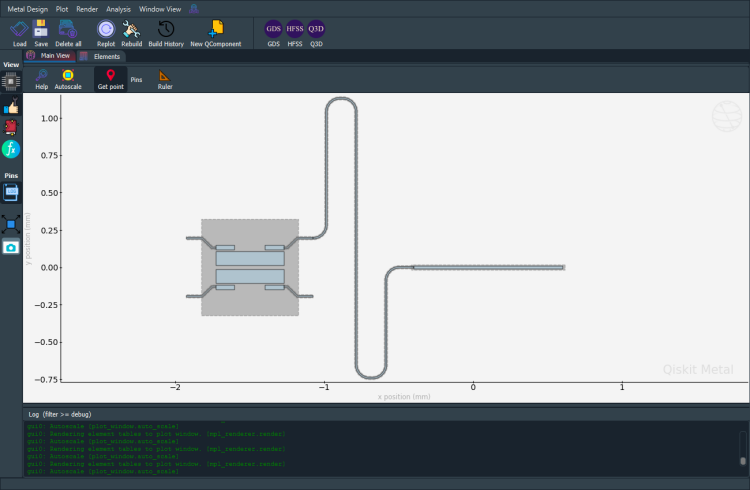

In [22]:
gui.screenshot()